### 02-Text-Blob-Sentiment-Analysis.ipynb
* **Script**: 02-Text-Blob-Sentiment-Analysis.ipynb
* **Purpose**: Run sentiment analysis on 1,000 most recent UA tweets pulled from the Twitter API using TextBlob
* **Input**: Tweets from Twitter API, .config (keys to access Twitter API)
* **Output**: graphics/textblob_sentiment_polarity.png

In [1]:
import cnfg
import tweepy
import pickle

import numpy as np
import pandas as pd

from os.path import expanduser
from pymongo import MongoClient
from textblob import TextBlob

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

client = MongoClient() #Boot Up MongoDB
united = client.airline_tweets.united #Create United Airlines Tweet Collection

#### Twitter API Authentication
**NOTE:** You will have to save get your own consumer key and secret and store in a .config file before this step. You can get these at [Twitter Apps](https://apps.twitter.com/), assuming you have a Twitter account.

In [2]:
home = expanduser("~")
config = cnfg.load(home + "/.twitter_config")
auth = tweepy.AppAuthHandler(config["consumer_key"], config["consumer_secret"])

api=tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Function to Load Tweets into MongoDB
* **colln**: Mongo Collection to load tweets into
* **handle**: Load tweets to this twitter handle into collection 
* **n**: number of tweets to load

In [10]:
def pull_tweets(colln, handle, n):    
    tweets = tweepy.Cursor(api.search, q=handle, lang="en", show_user=True).items(n)
    print "Rate Limit Status: ", api.rate_limit_status()["resources"]["search"]
    
    for tweet in tweets:
        tweet = tweet._json
        
        tweet["_id"] = tweet.pop("id")
        colln.insert_one(tweet)
        
    print colln, colln.count()

In [11]:
pull_tweets(united, "@United", 1000)

Rate Limit Status:  {u'/search/tweets': {u'reset': 1468011112, u'limit': 450, u'remaining': 448}}
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'airline_tweets'), u'united') 1000


#### Function to create TextBlob Sentiment Polarity histogram based on sentiment of Tweets from API
* **colln**: Mongo Collection to pull tweets from

In [25]:
def plot_polarity(colln):
    polarities = []
    tweets = colln.find()
    
    for tweet in tweets:
        polarity = TextBlob(tweet["text"]).sentiment.polarity
        polarities.append(polarity)
        
    plt.hist(polarities, bins=25)

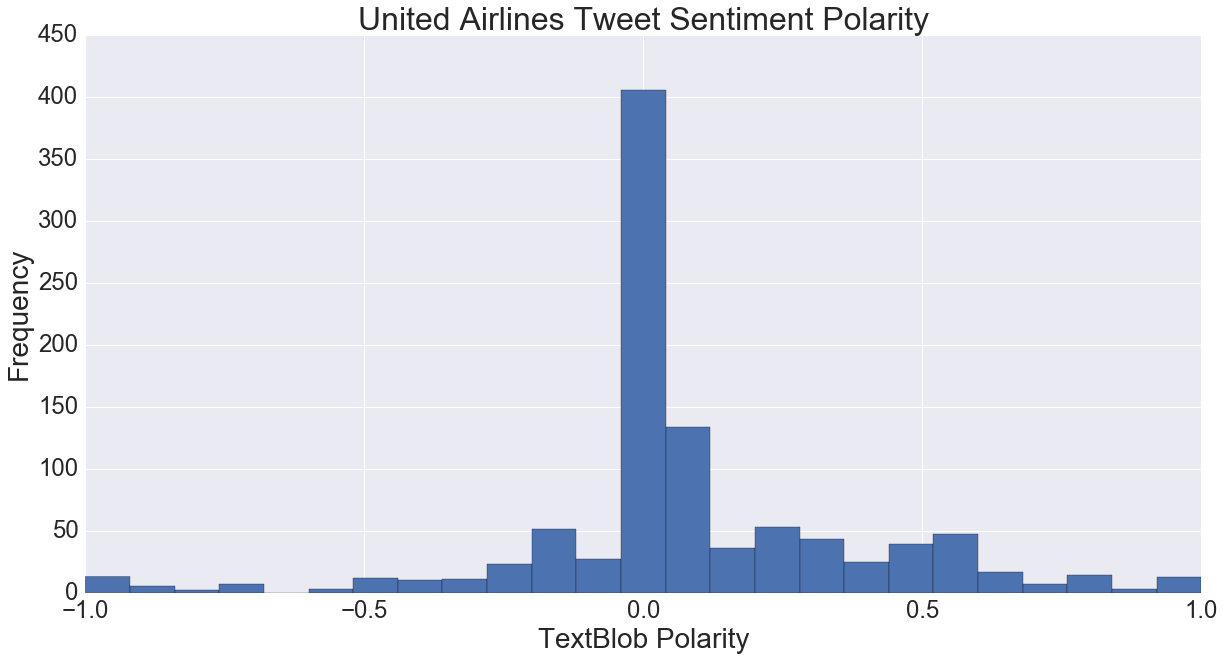

In [26]:
plt.figure(figsize=(20,10))
plot_polarity(united)

plt.tick_params(axis="x", labelsize=24)
plt.tick_params(axis="y", labelsize=24)

plt.xlabel("TextBlob Polarity", fontsize=28)
plt.ylabel("Frequency", fontsize=28)
plt.title("United Airlines Tweet Sentiment Polarity", fontsize=32)
plt.savefig("graphics/textblob_sentiment_polarity.png")